# STARDIS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage

from tardis.io.atom_data import AtomData

from astropy import units as u, constants as const

from stardis.plasma import AlphaLine, HMinusDensity, TracingNus, create_splasma
from stardis.opacities import calc_tau_h_minus, calc_tau_e, calc_tau_nus, calc_hminus_density, calc_tau_photo
from stardis.io import read_marcs_to_fv
from stardis.raytrace import bb_nu, bb_lambda, calc_weights, raytrace

Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

## Sun Spectrum

(1000.0, 9000.0)

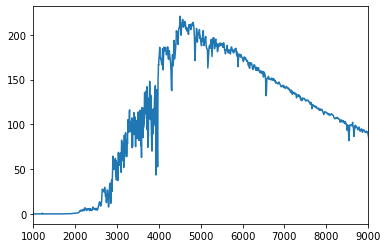

In [2]:
sun_spec = pd.read_csv('data/solar_data/NewGuey2003.txt', skiprows=20, delim_whitespace=True, names=['wave', 'flux'])
sun_spec['wave'] *= 10
sun_spec['flux'] = u.Quantity(sun_spec['flux'].to_numpy(), "W/(m2 nm)").to("erg/(s cm2 AA)").value
plt.plot(sun_spec.wave, sun_spec.flux)
plt.xlim(1000, 9000)

## Model & Atomic Data

In [3]:
adata = AtomData.from_hdf('kurucz_cd23_chianti_H_He.h5')
marcs_model_fv, marcs_abundances_all, temps = read_marcs_to_fv('data/marcs/sun.mod', adata, 30)
adata.prepare_atom_data(marcs_abundances_all.index.tolist())

## Wavelengths and Frequencies

In [4]:
tracing_lambda = np.arange(1000, 10000, 10) * u.Angstrom
tracing_nus = tracing_lambda.to(u.Hz, u.spectral())

## Plasma

In [5]:
splasma = create_splasma(marcs_model_fv, marcs_abundances_all, adata, tracing_nus)

## Optical Depths

In [6]:
tau_nus = calc_tau_nus(splasma, marcs_model_fv,tracing_nus)

In [7]:
tau_h_minus = calc_tau_h_minus(
    splasma,
    marcs_model_fv,
    tracing_nus,
    wbr_fpath="data/wishart_broad_reinhardt_cross_section.dat",
)

In [8]:
tau_e = calc_tau_e(splasma,marcs_model_fv,tracing_nus)

In [9]:
tau_photo_H = calc_tau_photo(splasma,marcs_model_fv,tracing_nus,(1,0,1),7.91e-18,8.22e14)

In [10]:
all_taus = [tau_nus, tau_h_minus, tau_e, tau_photo_H]

## Source Function

In [11]:
bb = bb_nu(tracing_nus, temps)

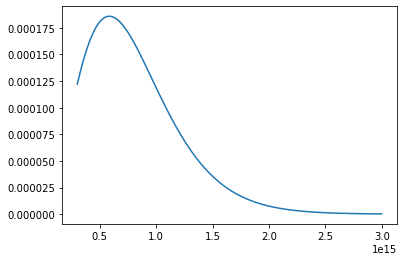

In [12]:
plt.plot(tracing_nus, bb[0])

## Ray tracing

In [13]:
I_nu = raytrace(bb, all_taus, tracing_nus, len(marcs_model_fv))

## Plotting

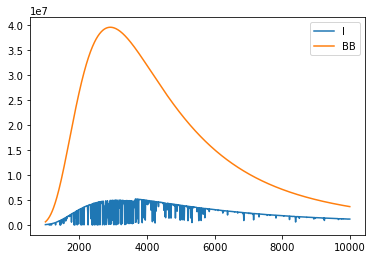

In [14]:
I_lambda = (I_nu[55])*tracing_nus/tracing_lambda

cur_bb = bb[0]*tracing_nus/tracing_lambda #TODO: check why 0, shouldn't it be 55 like I_nu?

plt.plot(tracing_lambda, I_lambda, label="I")
plt.plot(tracing_lambda, cur_bb, label="BB")
#plt.xlim(4330,4350) # to see 1st feature
#plt.xlim(6500, 6600) # to see last feature
#plt.xlim(2000,10000) 
plt.legend()

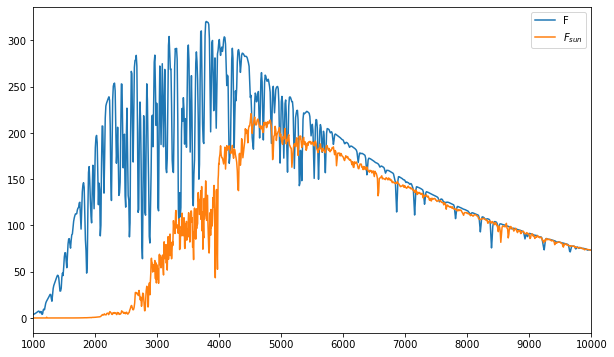

In [15]:
plt.figure(figsize=(10,6))
flux = 2*np.pi*1e-5*ndimage.gaussian_filter1d(I_lambda, 1)
plt.plot(tracing_lambda, flux, label="F")
plt.plot(sun_spec.wave, sun_spec.flux, label="$F_{sun}$")

plt.xlim((1000,10000))
plt.legend()

## Scratch Work

In [16]:
kappaross_diff = -np.diff(marcs_model_fv.kappaross)
kappaross_diff = kappaross_diff
kappaross_diff = np.append(kappaross_diff,marcs_model_fv.kappaross[54])
kappaross_diff;

In [17]:
tauross = kappaross_diff*marcs_model_fv.density*marcs_model_fv.cell_length
tauross;